In [181]:
import numpy as np
from timeit import default_timer as timer
from datetime import timedelta
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
import plotly.io as pio
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from autoencoder import combined_loss
import tensorflow as tf
from skopt import gp_minimize
from autoencoder import objective_function_tf
from sklearn.gaussian_process.kernels import Matern


from cordex_discrete import cordex_discrete
from cordex_continuous import cordex_continuous
from plot_fun import subplot_results
from Jcb import calc_basis_matrix, Jcb

from autoencoder import create_train_val_set, create_autoencoder, create_autoencoder_enhanced, fit_autoencoder, fit_denoising_autoencoder, plot_history, fit_vae, create_vae, fit_autoencoder_custom
from latent_bo import objective_function

### Helpers

In [133]:
def optimize_designs(encoder, decoder, encoder_noisy, decoder_noisy, cordex_discrete, objective_function, runs, n_x, scalars, optimality, J_cb, n_repetitions=10, n_iterations=3, use_denoising=True, use_normal=True):
    results = []
    all_designs = []

    for rep in tqdm(range(n_repetitions)):
        cordex_mat, cordex_opt = cordex_discrete(runs=runs,
                                                 f_list=n_x,
                                                 scalars=scalars,
                                                 levels=[-1, 1],
                                                 epochs=5,
                                                 optimality=optimality,
                                                 J_cb=J_cb,
                                                 disable_bar=True)

        objective_function_values = [cordex_opt]
        designs = [cordex_mat]


        if use_denoising:
            for i in range(n_iterations):
                encoded_denoise = encoder_noisy.predict(np.reshape(cordex_mat, (1, -1)), verbose=0)
                decoded_denoise = decoder_noisy.predict(encoded_denoise, verbose=0).reshape(cordex_mat.shape)

                obj_val = objective_function(np.round(decoded_denoise), m=runs, n=sum(n_x), J_cb=J_cb, noise=0)
                objective_function_values.append(obj_val)

                designs.append(decoded_denoise)
                cordex_mat = decoded_denoise
        if use_normal:
            for j in range(n_iterations):
                encoded_result = encoder.predict(np.reshape(cordex_mat, (1, -1)), verbose=0)
                decoded_result = decoder.predict(encoded_result, verbose=0).reshape(cordex_mat.shape)

                obj_val = objective_function(np.round(decoded_result), m=runs, n=sum(n_x), J_cb=J_cb, noise=0)
                objective_function_values.append(obj_val)

                designs.append(decoded_result)
                cordex_mat = decoded_result

        results.append(objective_function_values)
        all_designs.append(designs)

    return results, all_designs

def find_best_design(results, all_designs):
    results = np.array(results)
    min_row, min_col = np.unravel_index(np.argmin(results, axis=None), results.shape)
    best_obj_val = results[min_row, min_col]
    best_design = all_designs[min_row][min_col]

    return best_obj_val, best_design

def find_minima_grid(decoder, objective_function, runs, n_x, J_cb, xy_points=100):
    # Create a grid of points in the 2D latent space
    x = np.linspace(-1, 1, xy_points)
    y = np.linspace(-1, 1, xy_points)
    x_grid, y_grid = np.meshgrid(x, y)
    latent_points = np.vstack([x_grid.ravel(), y_grid.ravel()]).T

    # Use the decoder to transform the points back to the original space
    decoded_points = decoder.predict(latent_points)

    # Calculate the objective function values for each point
    z_values = np.array([objective_function(point, m=runs, n=sum(n_x), J_cb=J_cb, noise=0) for point in decoded_points])

    # Find the minimum value
    min_value = np.min(z_values)

    # Get all points where the objective function value equals the minimum value
    minima_points = latent_points[z_values == min_value]

    return minima_points.tolist()

def create_train_val_set_random(runs, n_x, scalars, optimality, J_cb,
                                num_designs=1000, test_size=0.2, random_state=42, noise=None, max_iterations=100000, epsilon=1e-10):

    design_matrices = []
    valid_count = 0
    for _ in tqdm(range(max_iterations)):
        if valid_count >= num_designs:
            break

        candidate_matrix = np.random.uniform(-1, 1, size=(runs, n_x[0]))

        Z = np.hstack([np.ones((runs, 1)), candidate_matrix @ J_cb])
        ZTZ = Z.T @ Z
        determinant = np.linalg.det(ZTZ)

        if determinant > epsilon:
            design_matrices.append(candidate_matrix)
            valid_count += 1

    if valid_count < num_designs:
        print(f"Warning: Only {valid_count} valid design matrices found after {max_iterations} iterations")

    design_matrices = np.stack(design_matrices)

    scaler = MinMaxScaler(feature_range=(-1, 1))
    normalized_designs = scaler.fit_transform(design_matrices.reshape(num_designs, -1))

    if noise is not None:
        noisy_designs = normalized_designs + noise * np.random.normal(size=normalized_designs.shape)
        noisy_designs = np.clip(noisy_designs, -1, 1)

        x_train, x_val, y_train, y_val = train_test_split(noisy_designs, normalized_designs, test_size=test_size,
                                                          random_state=random_state)
        return x_train, x_val, y_train, y_val
    else:
        train_data, val_data = train_test_split(normalized_designs, test_size=test_size, random_state=random_state)
        return train_data, val_data

def plot_3d(decoder, objective_function, runs, n_x, J_cb, filename='interactive_3d_with_minimum.html', xy_points=1_000):
    # Create a grid of points in the 2D latent space
    x = np.linspace(-1, 1, xy_points)
    y = np.linspace(-1, 1, xy_points)
    x_grid, y_grid = np.meshgrid(x, y)
    latent_points = np.vstack([x_grid.ravel(), y_grid.ravel()]).T

    # Use the decoder to transform the points back to the original space
    decoded_points = decoder.predict(latent_points)

    # Calculate the objective function values for each point
    z_values = np.array([objective_function(point, m=runs, n=sum(n_x), J_cb=J_cb, noise=0) for point in decoded_points])

    # Reshape the z_values to match the grid shape
    z_grid = z_values.reshape(x_grid.shape)

    # Find the index of the minimum value in z_values
    min_index = np.argmin(z_values)

    # Find the corresponding point in the latent space and the original space
    min_latent_point = latent_points[min_index]
    min_decoded_point = decoded_points[min_index]
    min_z_value = z_values[min_index]

    # Create the interactive 3D surface plot with the marked minimum
    fig = go.Figure(data=[
        go.Surface(x=x_grid, y=y_grid, z=z_grid, colorscale='Viridis', reversescale=True),
        go.Scatter3d(x=[min_latent_point[0]], y=[min_latent_point[1]], z=[min_z_value],
                     mode='markers', marker=dict(size=8, color='red', symbol='circle'))
    ])

    fig.update_layout(scene=dict(xaxis_title='Latent Dimension 1',
                                 yaxis_title='Latent Dimension 2',
                                 zaxis_title='Objective Function Value'),
                      title='Interactive 3D Surface Plot with Minimum')

    # Save the interactive plot to an HTML file
    pio.write_html(fig, file=filename, auto_open=True)


def plot_contour(decoder, objective_function, runs, n_x, J_cb, levels=5, xy_points=1_000):
    # Create a grid of points in the 2D latent space
    x = np.linspace(-1, 1, xy_points)
    y = np.linspace(-1, 1, xy_points)
    x_grid, y_grid = np.meshgrid(x, y)
    latent_points = np.vstack([x_grid.ravel(), y_grid.ravel()]).T

    # Use the decoder to transform the points back to the original space
    decoded_points = decoder.predict(latent_points)

    # Calculate the objective function values for each point
    z_values = np.array([objective_function(point, m=runs, n=sum(n_x), J_cb=J_cb, noise=0) for point in decoded_points])

    # Reshape the z_values to match the grid shape
    z_grid = z_values.reshape(x_grid.shape)

    # Plot colored contour lines
    fig, ax = plt.subplots()
    contour = ax.contour(x_grid, y_grid, z_grid, levels=levels, cmap='viridis')  # use a colormap here
    # fig.colorbar(contour)  # Add a colorbar
    ax.set_xlabel('Latent Dimension 1')
    ax.set_ylabel('Latent Dimension 2')
    plt.title('Contour plot of the Objective Function Value')
    plt.show()

In [92]:
def plot_3d_v2(decoder, objective_function, runs, n_x, J_cb, chosen_points, filename='interactive_3d_with_minimum.html', xy_points=1_000):
    # Create a grid of points in the 2D latent space
    x = np.linspace(-1, 1, xy_points)
    y = np.linspace(-1, 1, xy_points)
    x_grid, y_grid = np.meshgrid(x, y)
    latent_points = np.vstack([x_grid.ravel(), y_grid.ravel()]).T

    # Use the decoder to transform the points back to the original space
    decoded_points = decoder.predict(latent_points)

    # Calculate the objective function values for each point
    z_values = np.array([objective_function(point, m=runs, n=sum(n_x), J_cb=J_cb, noise=0) for point in decoded_points])

    # Reshape the z_values to match the grid shape
    z_grid = z_values.reshape(x_grid.shape)

    # Find the index of the minimum value in z_values
    min_index = np.argmin(z_values)

    # Find the corresponding point in the latent space and the original space
    min_latent_point = latent_points[min_index]
    min_decoded_point = decoded_points[min_index]
    min_z_value = z_values[min_index]

    # Calculate the objective function values for the chosen points
    chosen_points_decoded = decoder.predict(np.array(chosen_points))
    chosen_points_values = np.array([objective_function(point, m=runs, n=sum(n_x), J_cb=J_cb, noise=0) for point in chosen_points_decoded])

    # Create a color gradient from blue to red for the chosen points
    num_chosen_points = len(chosen_points)
    colors = [f"hsl(240, 100%, {100 * i / num_chosen_points}%)"
              for i in range(num_chosen_points)]

    # Create the interactive 3D surface plot with the marked minimum and chosen points
    fig = go.Figure(data=[
        go.Surface(x=x_grid, y=y_grid, z=z_grid, colorscale='Viridis', reversescale=True),
        go.Scatter3d(x=[min_latent_point[0]], y=[min_latent_point[1]], z=[min_z_value],
                     mode='markers', marker=dict(size=8, color='red', symbol='circle')),
        go.Scatter3d(x=[p[0] for p in chosen_points], y=[p[1] for p in chosen_points], z=chosen_points_values,
                     mode='lines+markers', line=dict(color=colors), marker=dict(size=6, color=colors))
    ])

    fig.update_layout(scene=dict(xaxis_title='Latent Dimension 1',
                                 yaxis_title='Latent Dimension 2',
                                 zaxis_title='Objective Function Value'),
                      title='Interactive 3D Surface Plot with Minimum and Chosen Points')

    # Save the interactive plot to an HTML file
    pio.write_html(fig, file=filename, auto_open=True)

In [115]:
from matplotlib import cm
from matplotlib.colors import to_hex

def plot_3d_v3(decoder, objective_function, runs, n_x, J_cb, chosen_points, filename='interactive_3d_with_minimum.html', xy_points=1_000, scale='viridis'):
    # Create a grid of points in the 2D latent space
    x = np.linspace(-1, 1, xy_points)
    y = np.linspace(-1, 1, xy_points)
    x_grid, y_grid = np.meshgrid(x, y)
    latent_points = np.vstack([x_grid.ravel(), y_grid.ravel()]).T

    # Use the decoder to transform the points back to the original space
    decoded_points = decoder.predict(latent_points)

    # Calculate the objective function values for each point
    z_values = np.array([objective_function(point, m=runs, n=sum(n_x), J_cb=J_cb, noise=0) for point in decoded_points])

    # Reshape the z_values to match the grid shape
    z_grid = z_values.reshape(x_grid.shape)

    # Calculate objective function values for chosen points
    chosen_points_values = np.array([objective_function(decoder.predict([p]).flatten(), m=runs, n=sum(n_x), J_cb=J_cb, noise=0) for p in chosen_points])

    # Create the interactive 3D surface plot with the chosen points connected by a line
    fig = go.Figure(data=[
        go.Surface(x=x_grid, y=y_grid, z=z_grid, colorscale=scale, reversescale=True)
    ])

    # Color scale for line gradient
    color_scale = cm.get_cmap(scale)
    num_chosen_points = len(chosen_points)
    colors = [to_hex(color_scale(i / num_chosen_points)) for i in range(num_chosen_points)]

    # Create a scatter plot for the chosen points
    fig.add_trace(
        go.Scatter3d(x=[p[0] for p in chosen_points],
                     y=[p[1] for p in chosen_points],
                     z=chosen_points_values + 0.01,  # added a constant here
                     mode='lines+markers+text',
                     text=[str(i) for i in range(num_chosen_points)],
                     line=dict(color=colors),
                     marker=dict(size=6, color=colors),
                     showlegend=False)
    )

    colorbar = go.Scatter3d(
        x=[None], y=[None], z=[None],
        mode='markers',
        marker=dict(size=0, color=np.linspace(0, 1, 100), colorscale=scale, colorbar=dict(title="Iterations")),
        hoverinfo='none'
    )
    # fig.add_trace(colorbar)

    fig.update_layout(scene=dict(xaxis_title='Latent Dimension 1',
                                 yaxis_title='Latent Dimension 2',
                                 zaxis_title='Objective Function Value'),
                      title='Interactive 3D Surface Plot with Minimum')

    # Save the interactive plot to an HTML file
    pio.write_html(fig, file=filename, auto_open=True)

In [129]:
from matplotlib import cm
from matplotlib.colors import to_hex

def plot_3d_v4(decoder, objective_function, runs, n_x, J_cb, chosen_points, true_minima, filename='interactive_3d_with_minimum.html', xy_points=100, scale='viridis'):
    # Create a grid of points in the 2D latent space
    x = np.linspace(-1, 1, xy_points)
    y = np.linspace(-1, 1, xy_points)
    x_grid, y_grid = np.meshgrid(x, y)
    latent_points = np.vstack([x_grid.ravel(), y_grid.ravel()]).T

    # Use the decoder to transform the points back to the original space
    decoded_points = decoder.predict(latent_points)

    # Calculate the objective function values for each point
    z_values = np.array([objective_function(point, m=runs, n=sum(n_x), J_cb=J_cb, noise=0) for point in decoded_points])

    # Reshape the z_values to match the grid shape
    z_grid = z_values.reshape(x_grid.shape)

    # Calculate objective function values for chosen points
    chosen_points_values = np.array([objective_function(decoder.predict([p]).flatten(), m=runs, n=sum(n_x), J_cb=J_cb, noise=0) for p in chosen_points])

    # Calculate objective function values for true minimum points
    true_minima_values = np.array([objective_function(decoder.predict([p]).flatten(), m=runs, n=sum(n_x), J_cb=J_cb, noise=0) for p in true_minima])

    # Create the interactive 3D surface plot with the chosen points connected by a line
    fig = go.Figure(data=[
        go.Surface(x=x_grid, y=y_grid, z=z_grid, colorscale=scale, reversescale=True)
    ])

    # Color scale for line gradient
    color_scale = cm.get_cmap(scale)
    num_chosen_points = len(chosen_points)
    colors = [to_hex(color_scale(i / num_chosen_points)) for i in range(num_chosen_points)]

    # Create a scatter plot for the chosen points
    fig.add_trace(
        go.Scatter3d(x=[p[0] for p in chosen_points],
                     y=[p[1] for p in chosen_points],
                     z=chosen_points_values + 0.01,  # added a constant here
                     mode='lines+markers+text',
                     text=[str(i) for i in range(num_chosen_points)],
                     line=dict(color=colors),
                     marker=dict(size=6, color=colors),
                     showlegend=False)
    )

    # Create a scatter plot for the true minima
    fig.add_trace(
        go.Scatter3d(x=[p[0] for p in true_minima],
                     y=[p[1] for p in true_minima],
                     z=true_minima_values + 0.02,  # added a slightly higher constant here
                     mode='markers',
                     marker=dict(size=6, color='darkred'),
                     name='True minima')
    )

    fig.update_layout(scene=dict(xaxis_title='Latent Dimension 1',
                                 yaxis_title='Latent Dimension 2',
                                 zaxis_title='Objective Function Value'),
                      title='Interactive 3D Surface Plot with Minimum')

    # Save the interactive plot to an HTML file
    pio.write_html(fig, file=filename, auto_open=True)

### Settings

In [240]:
runs = 4
sub_x = 2
sub_y = 2
levels = np.linspace(-1,1,3).tolist()
optimality = 'A'
n_x = [100]
n_b = [3]
scalars = 0
J_cb = Jcb(*[calc_basis_matrix(x_basis=x, b_basis=b) for x, b in zip(n_x, n_b)])

### Cordex

In [208]:
start = timer()
results, best_cr = cordex_continuous(runs=runs,
                                   f_list=n_x,
                                   scalars=scalars,
                                   epochs=1000,
                                   J_cb=J_cb,
                                   optimality=optimality,)
end = timer()
print(f"Optimality: {optimality}"
      f"\nBest criterion: {np.round(best_cr,3)}"
      f"\nExecution time (s): {timedelta(seconds=end-start)}")

100%|██████████| 1000/1000 [03:01<00:00,  5.51it/s]


Optimality: A
Best criterion: 208.843
Execution time (s): 0:03:04.334536


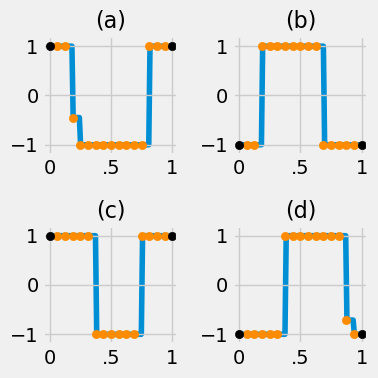

In [209]:
subplot_results(sub_x=sub_x, sub_y=sub_y, T=np.linspace(0,1,100), results=results)

### Autoencoder

In [248]:
def objective(latent_var):
    latent_var = np.array(latent_var).reshape(1, -1)
    decoded = decoder.predict(latent_var)
    y_true = objective_function(decoded, m=runs, n=sum(n_x), J_cb=J_cb, noise=0)
    return y_true

In [273]:
start = timer()
des_pure_train, des_pure_val,\
des_noisy_train, des_noisy_val = create_train_val_set_random(runs=runs,
                                                             n_x=n_x,
                                                             scalars=scalars,
                                                             optimality=optimality,
                                                             J_cb=J_cb,
                                                             noise=0.9,
                                                             num_designs=1_000,
                                                             epsilon=1e-10)

  2%|▏         | 2248/100000 [00:00<00:01, 49650.06it/s]


Epoch 1/1000
7/7 [==============================] - 1s 26ms/step - loss: 255811.0781 - val_loss: 14481.4463
Epoch 2/1000
7/7 [==============================] - 0s 6ms/step - loss: 11345.1152 - val_loss: 8179.4858
Epoch 3/1000
7/7 [==============================] - 0s 6ms/step - loss: 6668.9292 - val_loss: 4996.0566
Epoch 4/1000
7/7 [==============================] - 0s 5ms/step - loss: 4065.4707 - val_loss: 3081.7319
Epoch 5/1000
7/7 [==============================] - 0s 7ms/step - loss: 2578.1116 - val_loss: 2082.6057
Epoch 6/1000
7/7 [==============================] - 0s 6ms/step - loss: 1798.3795 - val_loss: 1481.6868
Epoch 7/1000
7/7 [==============================] - 0s 5ms/step - loss: 1295.2859 - val_loss: 1091.6069
Epoch 8/1000
7/7 [==============================] - 0s 5ms/step - loss: 966.8869 - val_loss: 820.1846
Epoch 9/1000
7/7 [==============================] - 0s 5ms/step - loss: 735.8811 - val_loss: 638.6913
Epoch 10/1000
7/7 [==============================] - 0s 5ms/ste

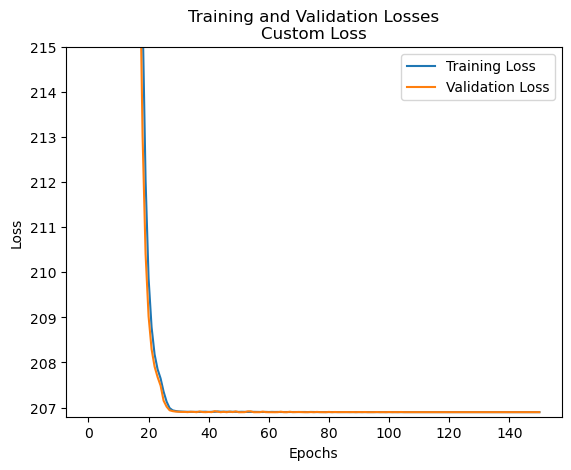

In [276]:
autoencoder, encoder, decoder, history = fit_autoencoder_custom(create_autoencoder,
                                                                train_data=des_pure_train, val_data=des_pure_val,
                                                                input_dim=des_pure_train.shape[1], latent_dim=40, patience=100, epochs=1_000, batch_size=128,
                                                                alpha=1, m=runs, n=sum(n_x), J_cb=J_cb, noise=0, max_layers=10)
plot_history(history, title="Custom Loss", threshold=215)

Iteration No: 1 started. Evaluating function at random point.
1/1 [==============================] - 0s 33ms/step
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0690
Function value obtained: 289.5610
Current minimum: 289.5610
Iteration No: 2 started. Evaluating function at random point.
1/1 [==============================] - 0s 8ms/step
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0233
Function value obtained: 216.8516
Current minimum: 216.8516
Iteration No: 3 started. Evaluating function at random point.
1/1 [==============================] - 0s 9ms/step
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0276
Function value obtained: 211.2252
Current minimum: 211.2252
Iteration No: 4 started. Evaluating function at random point.
1/1 [==============================] - 0s 8ms/step
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0232
Function value obtained: 217.2479
Current minimum: 211.2252
Iterati

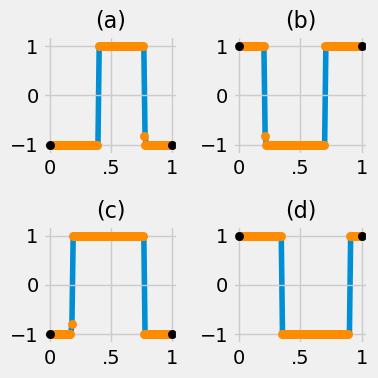

In [275]:
dimensions = [(np.min(des_pure_train), np.max(des_pure_train)) for _ in range(50)]
res = gp_minimize(objective, dimensions, n_calls=30, random_state=0, verbose=True, n_jobs=-1, n_random_starts=8, acq_func='EI', acq_optimizer='sampling')
end = timer()
optimal_latent_var = res.x
optimal_cr = res.fun

print(f"\n"
      f"Optimality: {optimality}"
      f"\nBest criterion: {np.round(optimal_cr,3)}"
      f"\nExecution time (s): {timedelta(seconds=end-start)}")
optimal_des = decoder.predict(np.array(optimal_latent_var).reshape(1, -1)).reshape(runs, sum(n_x))
subplot_results(sub_x=sub_x, sub_y=sub_y, T=np.linspace(0,1,100), results=optimal_des)

In [252]:
# results, all_designs = optimize_designs(encoder, decoder, encoder, decoder, cordex_discrete, objective_function, runs, n_x, scalars, optimality, J_cb, n_repetitions=10, n_iterations=10, use_denoising=False, use_normal=True)
# best_opt, best_des = find_best_design(results, all_designs)

### Latent space representations

#### Loss function smoothness

In [152]:
plot_3d(decoder, objective_function, runs, n_x, J_cb, filename='interactive_3d_with_minimum.html', xy_points=100)

313/313 [==============================] - 0s 407us/step


In [223]:
plot_3d_v3(decoder, objective_function, runs, n_x, J_cb, chosen_points=res.x_iters, scale='inferno', xy_points=100)

1/1 [==============================] - 0s 18ms/step


/var/folders/bb/tzggm8cx2f5fyxfhdmmhn7j40000gn/T/ipykernel_56487/3593840183.py:29: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



#### Robustness

7/7 [==============================] - 0s 1ms/step


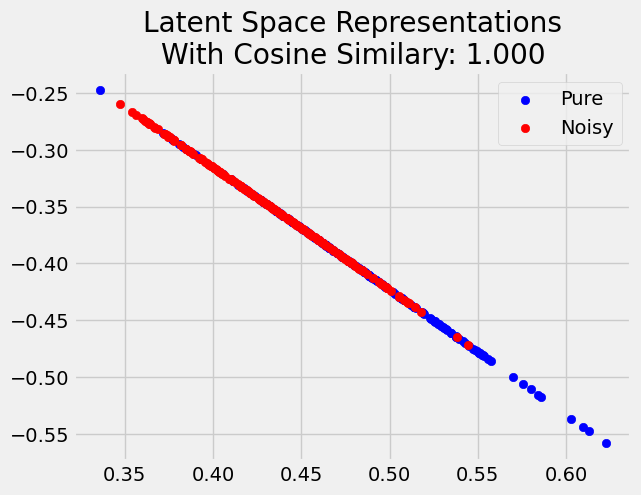

0.9996418


In [224]:
pure_embeddings = encoder.predict(des_pure_val)
noisy_embeddings = encoder.predict(des_noisy_val)
# Assuming `pure_embeddings` and `noisy_embeddings` are your embedding vectors
avg_cos_similarity = np.mean(cosine_similarity(pure_embeddings, noisy_embeddings))

plt.scatter(pure_embeddings[:, 0], pure_embeddings[:, 1], c='blue', label='Pure')
plt.scatter(noisy_embeddings[:, 0], noisy_embeddings[:, 1], c='red', label='Noisy')
plt.title(f'Latent Space Representations\nWith Cosine Similary: {avg_cos_similarity:.3f}')
plt.legend()
plt.show()
print(avg_cos_similarity)

#### Examples

##### Stability of Latent Space examples

1/1 [==============================] - 0s 99ms/step


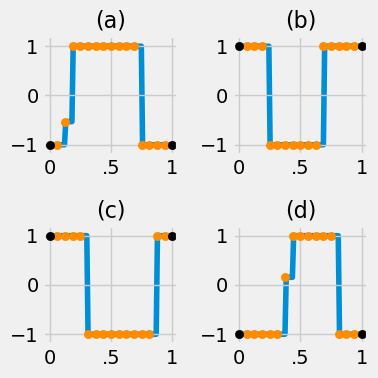

1/1 [==============================] - 0s 14ms/step
Bad example criterion: 210.18796357284


In [229]:
example_1 = np.array([1, 1]).reshape(1,2)
subplot_results(sub_x=sub_x, sub_y=sub_y, T=np.linspace(0,1,100), results=decoder.predict(example_1).reshape(runs, sum(n_x)))
print(f'Bad example criterion: {objective_function(decoder.predict(example_1).reshape(runs, sum(n_x)), runs, sum(n_x), J_cb)}')

##### Example 2

1/1 [==============================] - 0s 11ms/step


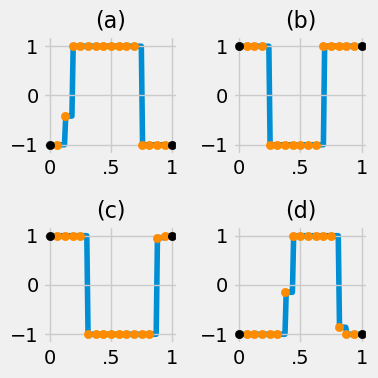

1/1 [==============================] - 0s 13ms/step
Bad example criterion: 209.86420142044315


In [230]:
example_2 = np.array([1, -1]).reshape(1,2)
subplot_results(sub_x=sub_x, sub_y=sub_y, T=np.linspace(0,1,100), results=decoder.predict(example_2).reshape(runs, sum(n_x)))
print(f'Bad example criterion: {objective_function(decoder.predict(example_2).reshape(runs, sum(n_x)), runs, sum(n_x), J_cb)}')

##### Example 3

1/1 [==============================] - 0s 12ms/step


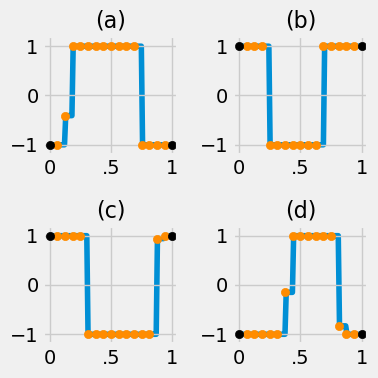

1/1 [==============================] - 0s 14ms/step
Bad example criterion: 209.85304978989578


In [231]:
example_3 = np.array([-1, 1]).reshape(1,2)
subplot_results(sub_x=sub_x, sub_y=sub_y, T=np.linspace(0,1,100), results=decoder.predict(example_3).reshape(runs, sum(n_x)))
print(f'Bad example criterion: {objective_function(decoder.predict(example_3).reshape(runs, sum(n_x)), runs, sum(n_x), J_cb)}')

##### Example 4

1/1 [==============================] - 0s 20ms/step


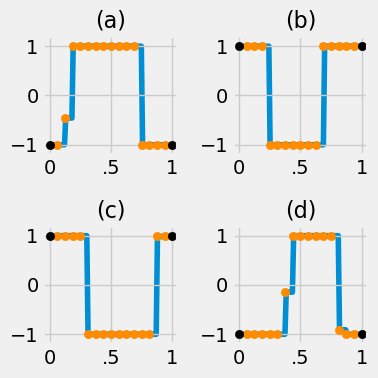

1/1 [==============================] - 0s 11ms/step
Bad example criterion: 209.93716298470775


In [232]:
example_4 = np.array([-1, -1]).reshape(1,2)
subplot_results(sub_x=sub_x, sub_y=sub_y, T=np.linspace(0,1,100), results=decoder.predict(example_4).reshape(runs, sum(n_x)))
print(f'Bad example criterion: {objective_function(decoder.predict(example_4).reshape(runs, sum(n_x)), runs, sum(n_x), J_cb)}')

#### Contour & Trajectory plot

31250/31250 [==============================] - 10s 313us/step


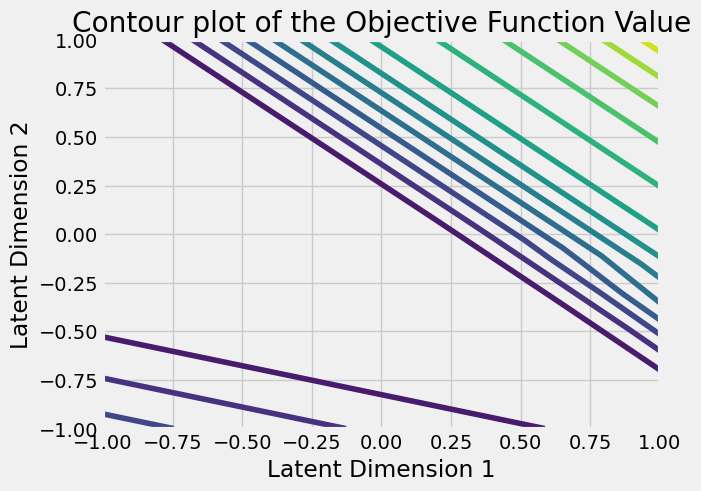

In [233]:
plot_contour(decoder, objective_function, runs, n_x, J_cb, levels=15, xy_points=100)